In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy
from scipy.optimize import fsolve
from math import factorial

In [2]:
fig_width_pt = 246.0  
inches_per_pt = 1.0/72.27             
golden_mean = (np.sqrt(5)-1.0)/2.0    
fig_width = fig_width_pt*inches_per_pt 
fig_height = fig_width/1.5 
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [fig_width, fig_height]
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'times'

In [3]:
M = 3   # number of large JJs in a SNAIL
EJ = 90 * 2*np.pi   # junction energy of larger JJ 
EL = 64 * 2*np.pi   # linear inductive energy of the SNAIL
EC = 177e-3 * 2*np.pi   # charging energy of the SNAIL 
beta = 0.147   # ratio between small and large JJ 
phi_ext = 0.35 * 2*np.pi   # external flux in SNAIL, e.g., 2pi = 1 flux quantum 

w_a = 2.97 * 2*np.pi   # frequency of Alice mode 
w_b = 6.915 * 2*np.pi   # frequency of Bob mode 

g_ac = 75.6e-3 * 2*np.pi   # coupling strength between Alice and SNAIL
g_bc = 134.9e-3 * 2*np.pi   # coupling strength between Bob and SNAIL 

chi_a_q = -766e-6 * 2*np.pi   # dispersive shift between Alice and its ancilla transmon
anh_a_q = -181e-3 * 2*np.pi   # anharmonicity of Alice's transmon
chi_b_q = -1104e-6 * 2*np.pi   # dispersive shift between Bob and its ancilla transmon
anh_b_q = -184e-3 * 2*np.pi   # anharmonicity of Bob's transmon

dim_SNAIL = 6   # level cutoff of SNAIL using oscillator basis (expanded around the equilibrium in potential)
dim_alice = 4   # level cutoff of Alice using oscillator basis 
dim_bob = 4   # level cutoff of Bob using oscillator basis 
dim = dim_SNAIL * dim_alice * dim_bob   # total dimension of the coupled system 

In [4]:
c_opt = tensor(qeye(dim_alice), destroy(dim_SNAIL), qeye(dim_bob))   # annihilation operator of SNAIL  
a_opt = tensor(destroy(dim_alice), qeye(dim_SNAIL), qeye(dim_bob))   # annihilation operator of Alice  
b_opt = tensor(qeye(dim_alice), qeye(dim_SNAIL), destroy(dim_bob))   # annihilation operator of Bob  

In [5]:
def potential_min(phi_min, phi_ext):
    return beta * np.sin(phi_min - phi_ext) + np.sin(phi_min/M)

In [6]:
phi_min = fsolve(potential_min, 0, args=phi_ext)[0]

# Taylor coefficients of the expansion around potential minimum [ref. B7]
c2 = beta * np.cos(phi_min - phi_ext) + np.cos(phi_min/M)/M
c3 = (M**2-1)/M**2 * np.sin(phi_min/M)
c4 = -beta * np.cos(phi_min - phi_ext) - np.cos(phi_min/M)/M**3
c5 = (1-M**4)/M**4 * np.sin(phi_min/M)

p = EL / (c2 * EJ + EL)

# renormalized coefficient due to the linear inductor [ref. B9]
c2_ti = p * c2
c3_ti = p**3 * c3
c4_ti = p**4 * (c4 - 3*c3**2/c2*(1-p))
c5_ti = p**5 *(c5 - 10*c4*c3/c2*(1-p) + 15*c3**3/c2**2*(1-p)**2)

# zero point fluctuation of the linearized SNAIL
phi_c = (2*EC / c2_ti / EJ)**0.25

# analytical approximation of SNAIL nonlinearity and frequency [ref. B8]
wc = np.sqrt(8*c2_ti*EC*EJ)
g3 = EJ * phi_c**3 * c3_ti / factorial(3)
g4 = EJ * phi_c**4 * c4_ti / factorial(4)
g5 = EJ * phi_c**5 * c5_ti / factorial(5)
anh = 12 * (g4 - 5 * g3**2/wc)

# construct the SNAIL Hamiltonian up to 5th order nonlinearity 
h_SNAIL = wc * c_opt.dag() * c_opt + g3 * (c_opt + c_opt.dag())**3 + g4 * (c_opt + c_opt.dag())**4 + g5 * (c_opt + c_opt.dag())**5

# constuct the coupled Alice--SNAIL--Bob Hamiltonian
# h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()+ a_opt)*(c_opt.dag()+ c_opt) + g_bc * (b_opt.dag()+ b_opt)*(c_opt.dag()+ c_opt)
# h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()*-1j*c_opt + a_opt*1j*c_opt.dag()) + g_bc * (b_opt.dag()*-1j*c_opt + b_opt*1j*c_opt.dag())
h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()*c_opt + a_opt*c_opt.dag()) + g_bc * (b_opt.dag()*c_opt + b_opt*c_opt.dag())

# h_tot = h_SNAIL + w_a * a_opt.dag() * a_opt + w_b * b_opt.dag() * b_opt + g_ac * (a_opt.dag()+ a_opt)*(1j*c_opt.dag()-1j* c_opt) + g_bc * (b_opt.dag()+ b_opt)*(1j*c_opt.dag()-1j* c_opt)






In [7]:
h0 = h_tot.full()
energy,U = np.linalg.eigh(h0)
omega_c1 = w_a
omega_c2 = w_b
indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
energyc11 = energy[indexc11]
indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
energyc21 = energy[indexc21]
detuning = np.abs((energyc11-energyc21)/2/np.pi)
detuning

3.957964371451262

In [19]:
def gaussian_ramp(t0, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0

    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function centered at t0
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
        else:
            # Return constant amplitude for t > t0
            return amplitude- amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))

    return time_dependent_function
func = gaussian_ramp(50, 0.5 * 2 * np.pi)

In [44]:
omega = detuning*2*np.pi
T = (2*np.pi)/omega
A = 0.5*2*np.pi
tlist = np.linspace(0, 5, 100000)  # Cover ten periods
def H1_coeff(t, args):
    return func(t) * np.sin(args['omega'] * t) 
H1 = (c_opt.dag() - c_opt) * 1j
H_d = [h_tot,[H1, H1_coeff]]
state100 = tensor(basis(dim_alice,1), 
                                basis(dim_SNAIL,0), 
                                basis(dim_bob, 0))
state001 = tensor(basis(dim_alice,0), 
                                basis(dim_SNAIL,0), 
                                basis(dim_bob, 1))
pstate100 = tensor(basis(dim_alice,1)*basis(dim_alice,1).dag(), 
                                qeye(dim_SNAIL), 
                                basis(dim_bob, 0)*basis(dim_bob, 0).dag())
pstate001 = tensor(basis(dim_alice,0)*basis(dim_alice,0).dag(), 
                                qeye(dim_SNAIL), 
                                basis(dim_bob, 1)*basis(dim_bob, 1).dag())
pstate002 = tensor(basis(dim_alice,0)*basis(dim_alice,0).dag(), 
                                qeye(dim_SNAIL), 
                                basis(dim_bob, 2)*basis(dim_bob, 2).dag())
pstate200 = tensor(basis(dim_alice,2)*basis(dim_alice,2).dag(), 
                                qeye(dim_SNAIL), 
                                basis(dim_bob, 0)*basis(dim_bob, 0).dag())
pstate101 = tensor(basis(dim_alice,1)*basis(dim_alice,1).dag(), 
                                qeye(dim_SNAIL), 
                                basis(dim_bob, 1)*basis(dim_bob, 1).dag())

In [45]:
args = {'omega': omega}
result = sesolve(H_d, state100, tlist, args=args)

In [46]:
import qutip as qt
qt.expect(pstate100,result.states[1])

0.9999999994359071

In [47]:
exp_P1 = np.array([expect(pstate100, state) for state in result.states])
exp_P2 = np.array([expect(pstate001, state) for state in result.states])
exp_P3 = np.array([expect(pstate200, state) for state in result.states])
exp_P4 = np.array([expect(pstate002, state) for state in result.states])
exp_P5 = np.array([expect(pstate101, state) for state in result.states])

(0.99, 1.0)

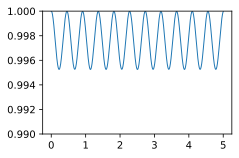

In [48]:
plt.plot(tlist,exp_P1)
plt.plot(tlist,exp_P2)
plt.plot(tlist,exp_P3+exp_P4+exp_P5)
plt.ylim(0.99,1)

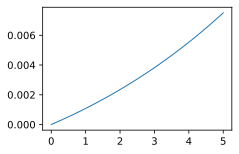

In [49]:
amplitude = []
for i in range(len(tlist)):
    amplitude.append(func(tlist[i]))
plt.plot(tlist,np.array(amplitude)/2/np.pi)

In [50]:
(np.array(amplitude)/2/np.pi)[0:50]

array([0.00000000e+00, 4.99911843e-08, 9.99827685e-08, 1.49974753e-07,
       1.99967137e-07, 2.49959921e-07, 2.99953105e-07, 3.49946689e-07,
       3.99940673e-07, 4.49935057e-07, 4.99929840e-07, 5.49925024e-07,
       5.99920608e-07, 6.49916592e-07, 6.99912975e-07, 7.49909759e-07,
       7.99906942e-07, 8.49904526e-07, 8.99902510e-07, 9.49900893e-07,
       9.99899677e-07, 1.04989886e-06, 1.09989844e-06, 1.14989843e-06,
       1.19989881e-06, 1.24989959e-06, 1.29990078e-06, 1.34990236e-06,
       1.39990434e-06, 1.44990673e-06, 1.49990951e-06, 1.54991269e-06,
       1.59991628e-06, 1.64992026e-06, 1.69992465e-06, 1.74992943e-06,
       1.79993461e-06, 1.84994020e-06, 1.89994618e-06, 1.94995256e-06,
       1.99995935e-06, 2.04996653e-06, 2.09997412e-06, 2.14998210e-06,
       2.19999048e-06, 2.24999927e-06, 2.30000845e-06, 2.35001804e-06,
       2.40002802e-06, 2.45003840e-06])

In [51]:
x_opt = c_opt+c_opt.dag()
y_opt = -1j*(c_opt - c_opt.dag())

In [52]:
alpha = np.array([expect(x_opt+y_opt, state) for state in result.states])

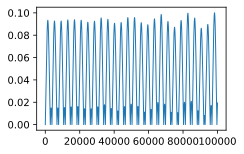

In [53]:
plt.plot(np.abs(alpha))